# Dataset Description

The dataset in question gathers detailed information about aeronautical accidents and incidents investigated by CENIPA, focusing on accident analysis and prevention. It is composed of several tables, each addressing different aspects of the events:

1. <u>ocorrencia.csv</u>: Contains general data about the occurrences, such as date, location, and information related to aeronautical safety events.
2. <u>ocorrencia_tipo.csv</u>: Specifies the type of occurrence, detailing the categories of incidents and accidents.
3. <u>aeronave.csv</u>: Presents data about the aircraft involved in the occurrences, such as model, manufacturer, and specific characteristics.
4. <u>fator_contribuinte.csv</u>: Records the factors that contributed to the occurrences, focusing on elements that influenced or caused the accident, in the investigated and finalized cases.
5. <u>recomendacao.csv</u>: Includes the safety recommendations generated from the investigations, aiming to prevent similar occurrences in the future.

Data available on the government website [here](https://dados.gov.br/dados/conjuntos-dados/ocorrencias-aeronauticas-da-aviacao-civil-brasileira).

# Questions for the dataset
<u>Question 1:</u> What are the places with the most occurrences?

<u>Question 2:</u> What is the model of the aircraft? How does this relate to the different classifications of accidents?

<u>Question 3:</u> What is the relationship between the type of flight, the number of fatalities, and seats? Is it consistent with what is expected?

<u>Question 4:</u> What is the profile of the factors that led to the occurrence?

<u>Question 5:</u> Do older aircraft tend to have more occurrences?

# Exploratory Data Analysis

## Preparation

### Libraries and Data Reading

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set(style='whitegrid')

In [56]:
fator_df = pd.read_csv('fator_contribuinte.csv', delimiter=';', encoding='latin1', na_values=['**','***','****','*******'])
ocorrencia_df = pd.read_csv('ocorrencia.csv', delimiter=';', encoding='latin1', na_values=['**','***','****','*******'])
aeronave_df = pd.read_csv('aeronave.csv', delimiter=';', encoding='latin1', na_values=['**','***','****','*******'])
tipo_df = pd.read_csv('ocorrencia_tipo.csv', delimiter=';', encoding='latin1', na_values=['**','***','****','*******'])
recomedacao_df = pd.read_csv('recomendacao.csv', delimiter=';', encoding='latin1', na_values=['**','***','****','*******'])

### Duplicates

It seems that there was some problem during data acquisition, where different occurrences may have received the same identification.

In [57]:
print("\033[1;31mDuplicated data based on the 'codigo_ocorrencia' column\033[0m")
print("ocorrencia\t\t", ocorrencia_df.duplicated(subset='codigo_ocorrencia').sum())
print("ocorrencia_tipo\t\t", tipo_df.duplicated(subset='codigo_ocorrencia1').sum())
print("aeronave\t\t", aeronave_df.duplicated(subset='codigo_ocorrencia2').sum())
print("fator_contribuinte\t", fator_df.duplicated(subset='codigo_ocorrencia3').sum())
print("recomendacao\t\t", recomedacao_df.duplicated(subset='codigo_ocorrencia4').sum())

Duplicated data based on the 'codigo_ocorrencia' column
ocorrencia		 0
ocorrencia_tipo		 463
aeronave		 105
fator_contribuinte	 6085
recomendacao		 2223


Let's remove duplicates and unify the data into a single DataFrame.

In [58]:
ocorrencia_df.drop_duplicates(subset='codigo_ocorrencia', inplace=True)
tipo_df.drop_duplicates(subset='codigo_ocorrencia1', inplace=True)
aeronave_df.drop_duplicates(subset='codigo_ocorrencia2', inplace=True)
fator_df.drop_duplicates(subset='codigo_ocorrencia3', inplace=True)
recomedacao_df.drop_duplicates(subset='codigo_ocorrencia4', inplace=True)

In [59]:
df = pd.merge(ocorrencia_df, aeronave_df, on='codigo_ocorrencia2', how='left')
df = pd.merge(df, tipo_df, on='codigo_ocorrencia1', how='left')
df = pd.merge(df, fator_df, on='codigo_ocorrencia3', how='left')
df = pd.merge(df, recomedacao_df, on='codigo_ocorrencia4', how='left')

Now that we have unified the datasets, we no longer need the foreign keys.

In [60]:
df.drop(['codigo_ocorrencia1', 'codigo_ocorrencia2', 'codigo_ocorrencia3', 'codigo_ocorrencia4'], axis=1, inplace=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9821 entries, 0 to 9820
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   codigo_ocorrencia                9821 non-null   int64  
 1   ocorrencia_classificacao         9821 non-null   object 
 2   ocorrencia_latitude              5976 non-null   object 
 3   ocorrencia_longitude             5976 non-null   object 
 4   ocorrencia_cidade                9821 non-null   object 
 5   ocorrencia_uf                    9813 non-null   object 
 6   ocorrencia_pais                  9821 non-null   object 
 7   ocorrencia_aerodromo             6657 non-null   object 
 8   ocorrencia_dia                   9821 non-null   object 
 9   ocorrencia_hora                  9819 non-null   object 
 10  investigacao_aeronave_liberada   6044 non-null   object 
 11  investigacao_status              8407 non-null   object 
 12  divulgacao_relatorio

Unfortunately, both fator_contribuinte and recomendacao have a much more reduced number of data now.

### Data Types

Most of the data are categorical, however, some variables can be treated for a specific type corresponding to the referred information, which facilitates its use during the analysis.

Latitude and longitude are considered as objects because their values are encoded as "444.444.444.121" for example, in addition to other symbols that are not numbers. Let's transform them into float.

In [62]:
df['ocorrencia_latitude'] = df['ocorrencia_latitude'].astype(str)
df['ocorrencia_longitude'] = df['ocorrencia_longitude'].astype(str)

In [63]:
def process_latitude_longitude(lat_str, lon_str):
    # Remove unwanted characters (like '*' and tabs) and extra spaces
    lat_str = lat_str.replace('*', '').replace('\\t', '').strip()
    lon_str = lon_str.replace('*', '').replace('\\t', '').strip()
    
    # Remove the degree symbol and replace commas with dots
    lat_str = lat_str.replace('°', '').replace(',', '.')
    lon_str = lon_str.replace('°', '').replace(',', '.')
    
    # Remove any extra spaces that may have been inadvertently included
    lat_str = lat_str.replace(' ', '')
    lon_str = lon_str.replace(' ', '')
    
    # If the latitude or longitude is empty after cleaning, return NaN
    if lat_str == '' or lon_str == '':
        return np.nan, np.nan
    
    # Handle cases where there are two consecutive negative signs (e.g. --15)
    if lat_str[0] == '-' and lat_str[1] == '-':
        lat_str = lat_str[1:]
    if lon_str[0] == '-' and lon_str[1] == '-':
        lon_str = lon_str[1:]

    # Step 1: Process Latitude
    first_dot_index_lat = lat_str.find('.')
    if first_dot_index_lat != -1:
        lat_cleaned = lat_str[:first_dot_index_lat + 1] + lat_str[first_dot_index_lat + 1:].replace('.', '')
        latitude = float(lat_cleaned)
    else:
        latitude = float(lat_str.replace('.', ''))  # If no dot, remove all dots and convert

    # Step 2: Process Longitude
    first_dot_index_lon = lon_str.find('.')
    if first_dot_index_lon != -1:
        lon_cleaned = lon_str[:first_dot_index_lon + 1] + lon_str[first_dot_index_lon + 1:].replace('.', '')
        longitude = float(lon_cleaned)
    else:
        longitude = float(lon_str.replace('.', ''))  # If no dot, remove all dots and convert

    return latitude, longitude

# Apply the function to the DataFrame columns
df[['ocorrencia_latitude', 'ocorrencia_longitude']] = df.apply(
    lambda row: pd.Series(process_latitude_longitude(row['ocorrencia_latitude'], row['ocorrencia_longitude'])),
    axis=1
)

Let's convert the temporal variables to datetime format.

In [64]:
df['ocorrencia_dia'] = pd.to_datetime(df['ocorrencia_dia'], format='%d/%m/%Y', errors='coerce')
df['divulgacao_dia_publicacao'] = pd.to_datetime(df['divulgacao_dia_publicacao'], format='%d/%m/%Y', errors='coerce')
df['recomendacao_dia_assinatura'] = pd.to_datetime(df['recomendacao_dia_assinatura'], format='%Y-%m-%d', errors='coerce')
df['recomendacao_dia_encaminhamento'] = pd.to_datetime(df['recomendacao_dia_encaminhamento'], format='%Y-%m-%d', errors='coerce')
df['recomendacao_dia_feedback'] = pd.to_datetime(df['recomendacao_dia_feedback'], format='%Y-%m-%d', errors='coerce')
df['ocorrencia_hora'] = pd.to_datetime(df['ocorrencia_hora'], format='%H:%M:%S', errors='coerce').dt.time

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9821 entries, 0 to 9820
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   codigo_ocorrencia                9821 non-null   int64         
 1   ocorrencia_classificacao         9821 non-null   object        
 2   ocorrencia_latitude              5974 non-null   float64       
 3   ocorrencia_longitude             5973 non-null   float64       
 4   ocorrencia_cidade                9821 non-null   object        
 5   ocorrencia_uf                    9813 non-null   object        
 6   ocorrencia_pais                  9821 non-null   object        
 7   ocorrencia_aerodromo             6657 non-null   object        
 8   ocorrencia_dia                   9821 non-null   datetime64[ns]
 9   ocorrencia_hora                  9819 non-null   object        
 10  investigacao_aeronave_liberada   6044 non-null   object     

## First Approach

In [66]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
codigo_ocorrencia,9821.0,61884.56033,28256.0,46152.0,64945.0,79955.0,83097.0,17458.164288
ocorrencia_latitude,5974.0,-61.561286,-996.583,-90.852083,-5.368056,-2.318167,296.961111,111.593953
ocorrencia_longitude,5973.0,-158.045679,-1000.6775,-433.691667,-5.804611,-4.713444,698.505556,226.32809
ocorrencia_dia,9821,2016-02-25 17:43:19.287241472,2007-01-01 00:00:00,2011-08-21 00:00:00,2015-11-05 00:00:00,2021-02-26 00:00:00,2023-12-31 00:00:00,NaN
divulgacao_dia_publicacao,2367,2017-08-19 18:36:57.490494208,2007-07-24 00:00:00,2014-08-15 00:00:00,2017-11-30 00:00:00,2020-10-02 00:00:00,2023-12-29 00:00:00,NaN
total_recomendacoes,9821.0,0.355361,0.0,0.0,0.0,0.0,83.0,1.599446
total_aeronaves_envolvidas,9821.0,1.010691,1.0,1.0,1.0,1.0,4.0,0.108628
aeronave_pmd,9821.0,21943.272376,0.0,1315.0,2250.0,23000.0,397000.0,40635.399585
aeronave_pmd_categoria,9821.0,21943.272376,0.0,1315.0,2250.0,23000.0,397000.0,40635.399585
aeronave_assentos,9368.0,37.650726,0.0,2.0,6.0,17.0,659.0,65.968323


### Distribution Analysis

array([[<Axes: title={'center': 'codigo_ocorrencia'}>,
        <Axes: title={'center': 'ocorrencia_latitude'}>,
        <Axes: title={'center': 'ocorrencia_longitude'}>,
        <Axes: title={'center': 'ocorrencia_dia'}>],
       [<Axes: title={'center': 'divulgacao_dia_publicacao'}>,
        <Axes: title={'center': 'total_recomendacoes'}>,
        <Axes: title={'center': 'total_aeronaves_envolvidas'}>,
        <Axes: title={'center': 'aeronave_pmd'}>],
       [<Axes: title={'center': 'aeronave_pmd_categoria'}>,
        <Axes: title={'center': 'aeronave_assentos'}>,
        <Axes: title={'center': 'aeronave_ano_fabricacao'}>,
        <Axes: title={'center': 'aeronave_fatalidades_total'}>],
       [<Axes: title={'center': 'recomendacao_dia_assinatura'}>,
        <Axes: title={'center': 'recomendacao_dia_encaminhamento'}>,
        <Axes: title={'center': 'recomendacao_dia_feedback'}>, <Axes: >]],
      dtype=object)

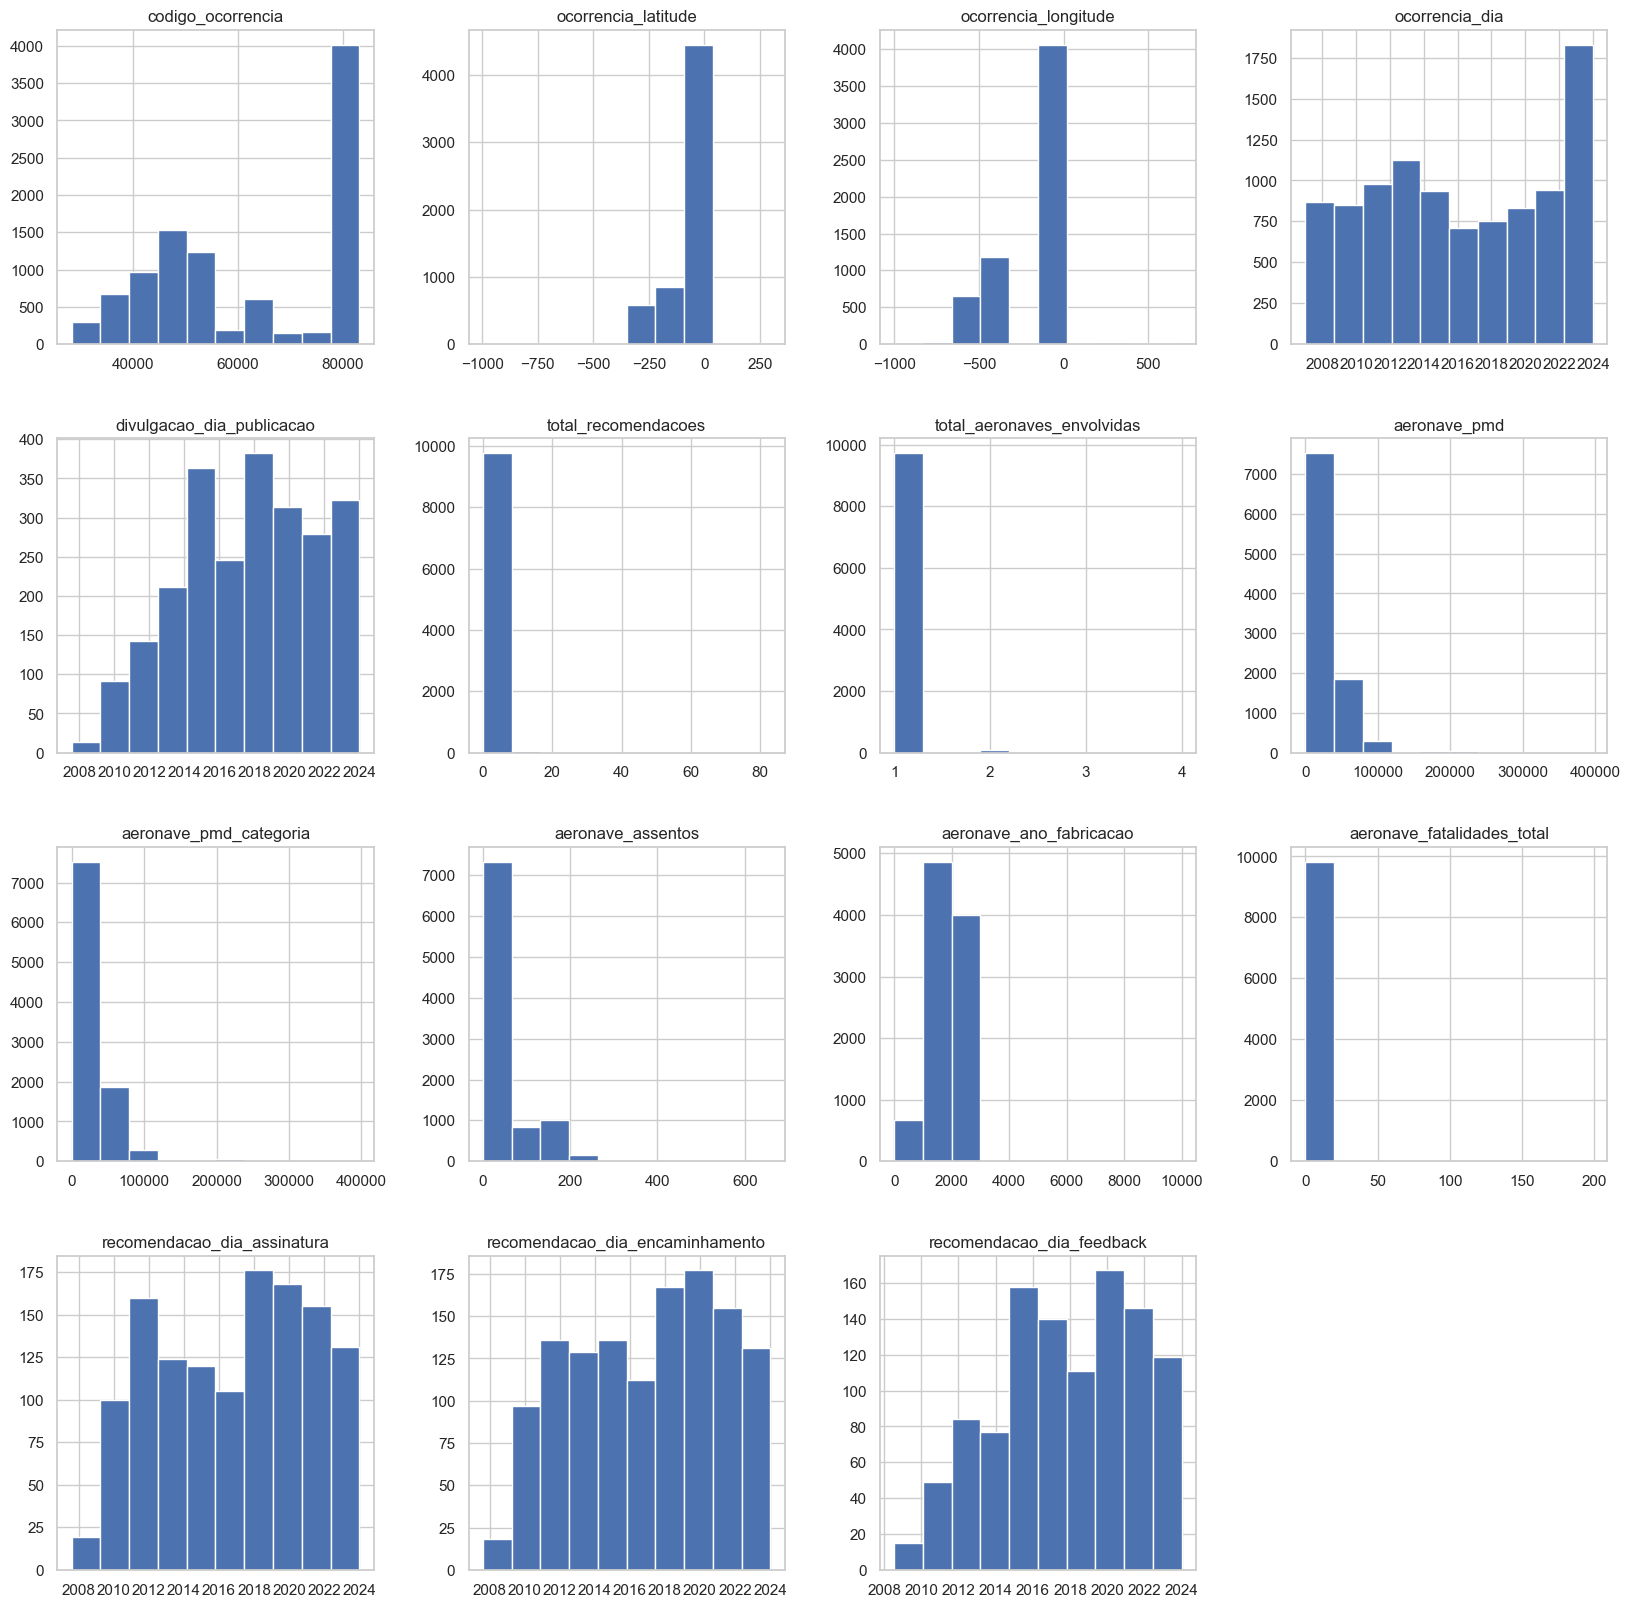

In [67]:
df.hist(figsize=(20,20))

It can be said that over the years the number of occurrences has increased, as the ocorrencia_dia of 2024 is the largest bar. However, the recommendations seem to be decreasing.

### Possible outliers

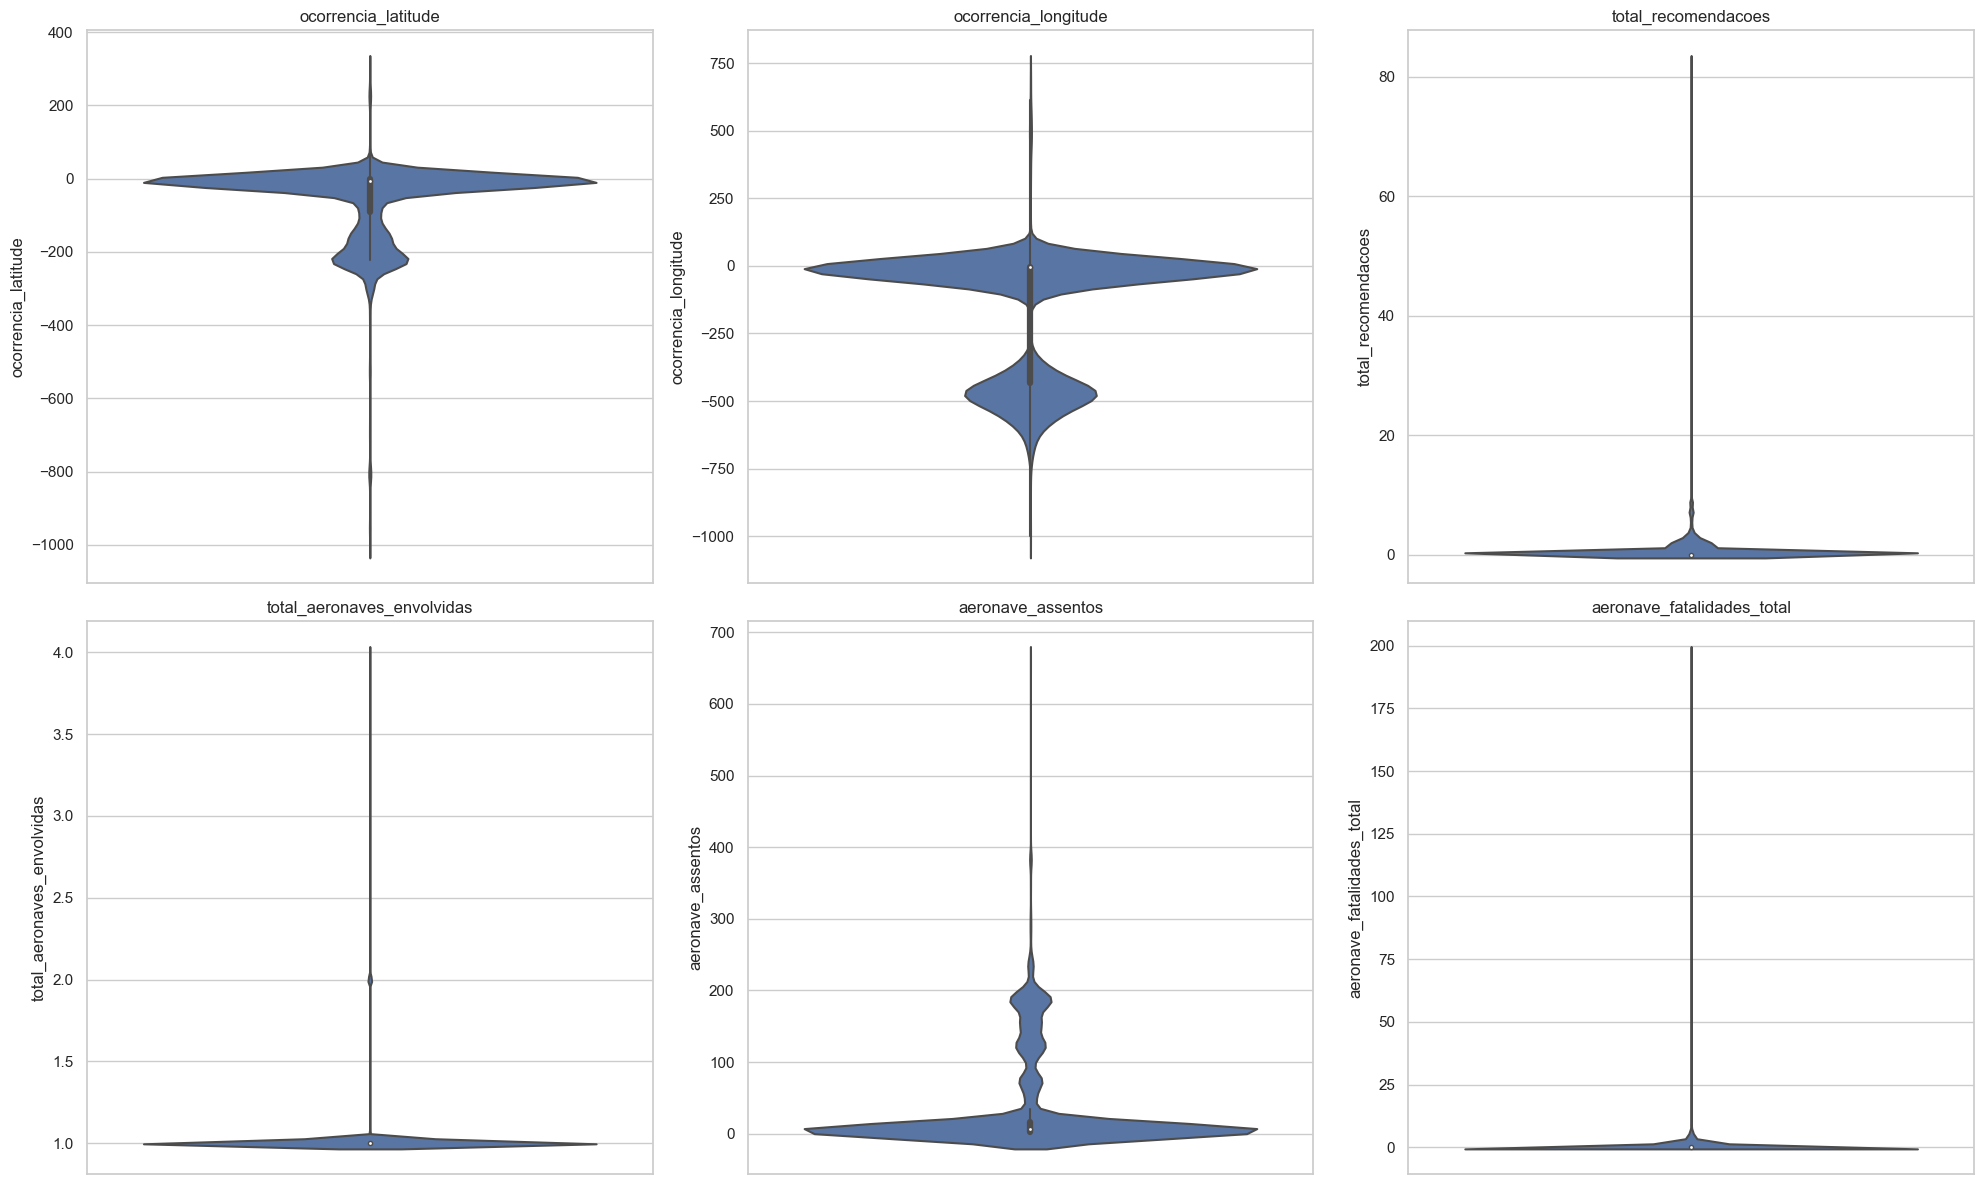

In [68]:
numerical_variables = ['ocorrencia_latitude',
                       'ocorrencia_longitude',
                       'total_recomendacoes',
                       'total_aeronaves_envolvidas',
                       'aeronave_assentos',
                       'aeronave_fatalidades_total']

fig, eixo = plt.subplots(2, 3, figsize=(20, 12))
for i in range(2 * 3):
    sns.violinplot(y=df[numerical_variables[i]], ax=eixo[i // 3][i % 3])
    eixo[i // 3][i % 3].set_title(numerical_variables[i])

plt.tight_layout()
plt.show()

It is noticed that there are some more serious occurrences, where more than one aircraft was involved, reaching up to four, which would be strange if it were not an incident, at least, on the ground (such as at the airport).  
These cases may also have generated a high number of recommendations or precautions, as shown by the total of up to around 80.  
Considering the latitude and longitude of Brazil on the map, there are many values that may have been recorded incorrectly or with wrong decimal places. In this sense, it is worth an analysis to clean these incorrect data.

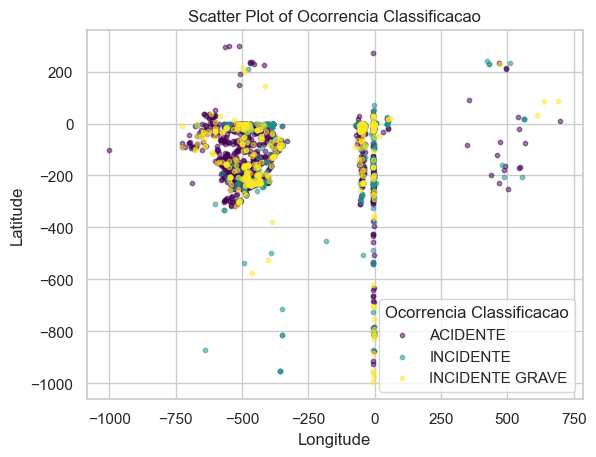

In [69]:
# Convert the 'ocorrencia_classificacao' column to numeric codes
unique_classes = df['ocorrencia_classificacao'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
class_color_map = dict(zip(unique_classes, colors))

# Plot the scatter plot using the colors for each class
for class_name, color in class_color_map.items():
    subset = df[df['ocorrencia_classificacao'] == class_name]
    plt.scatter(subset['ocorrencia_longitude'], subset['ocorrencia_latitude'], alpha=0.5, s=10,color=color, label=class_name)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Ocorrencia Classificacao')
plt.legend(title='Ocorrencia Classificacao')
plt.show()

It is possible to see that the ocorrencia_latitude and ocorrencia_longitude are out of scale. Given the position of Brazil according to these coordinates, we can infer that most of the data is 10 times larger than in reality, referring to the point cloud in the shape of Brazil. So, let's nullify the other values outside this cloud.

In [70]:
df.loc[(df['ocorrencia_latitude'] > 100) | (df['ocorrencia_latitude'] < -375), ['ocorrencia_latitude', 'ocorrencia_longitude']] = np.nan
df.loc[(df['ocorrencia_longitude'] > -250) | (df['ocorrencia_longitude'] < -750), ['ocorrencia_latitude', 'ocorrencia_longitude']] = np.nan

df['ocorrencia_latitude'] = df['ocorrencia_latitude'] / 10
df['ocorrencia_longitude'] = df['ocorrencia_longitude'] / 10

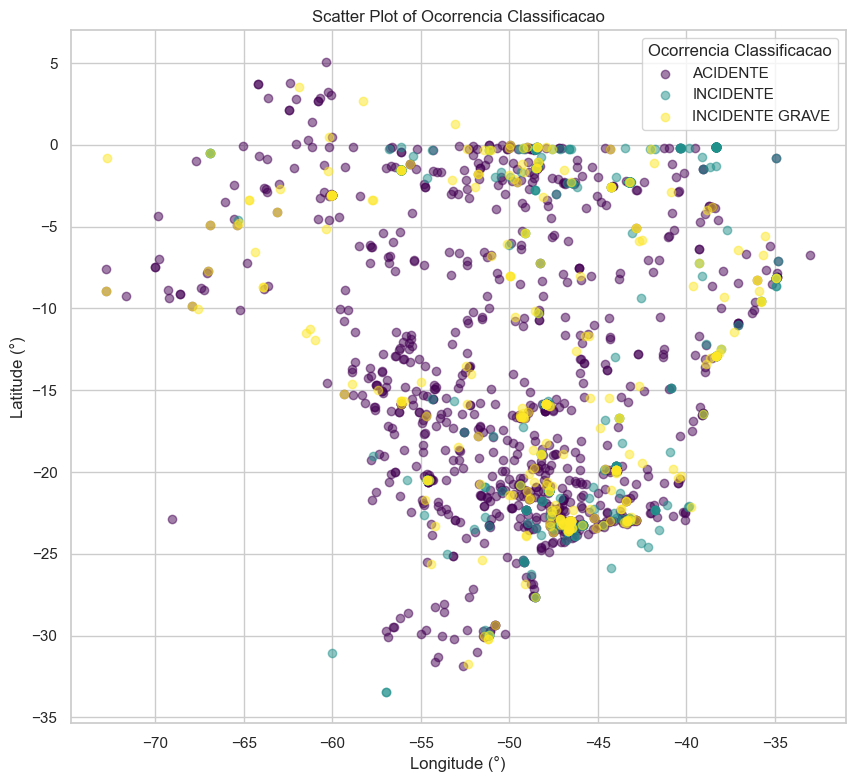

In [71]:
# Convert the 'ocorrencia_classificacao' column to numeric codes
unique_classes = df['ocorrencia_classificacao'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_classes)))
class_color_map = dict(zip(unique_classes, colors))

# Plot the scatter plot using the colors for each class
plt.figure(figsize=(10, 9))
for class_name, color in class_color_map.items():
    subset = df[df['ocorrencia_classificacao'] == class_name]
    plt.scatter(subset['ocorrencia_longitude'], subset['ocorrencia_latitude'], alpha=0.5, color=color, label=class_name)

plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.title('Scatter Plot of Ocorrencia Classificacao')
plt.legend(title='Ocorrencia Classificacao')
plt.show()

It can be seen that most occurrences are in the southeast region and most cases are accidents. But this is an analysis to be further explored later.

Another outlier we noticed when looking at the describe is the year of manufacture of the aircraft, as it has a minimum value of 0 and a maximum of 9999. Therefore, we will nullify these values.

In [72]:
df.loc[(df['aeronave_ano_fabricacao'] < 1900) | (df['aeronave_ano_fabricacao'] > 2024), 'aeronave_ano_fabricacao'] = np.nan

## Directed Analysis

### Question 1

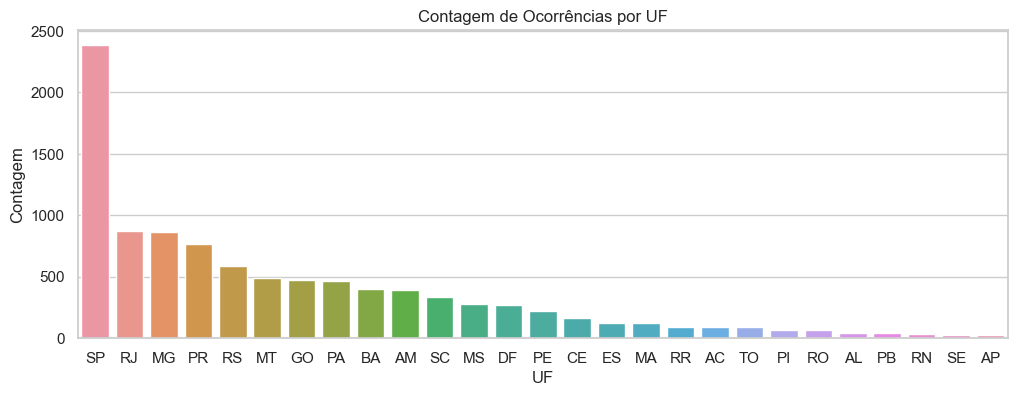

In [73]:
plt.figure(figsize=(12,4))
sns.countplot(x='ocorrencia_uf', data=df, order=df['ocorrencia_uf'].value_counts().index)
plt.title('Contagem de Ocorrências por UF')
plt.ylabel('Contagem')
plt.xlabel('UF')
plt.show()

It is possible to see that most occurrences are present in the southeast and south, regions that indicate the highest traffic of people, as the previously presented map pointed out.

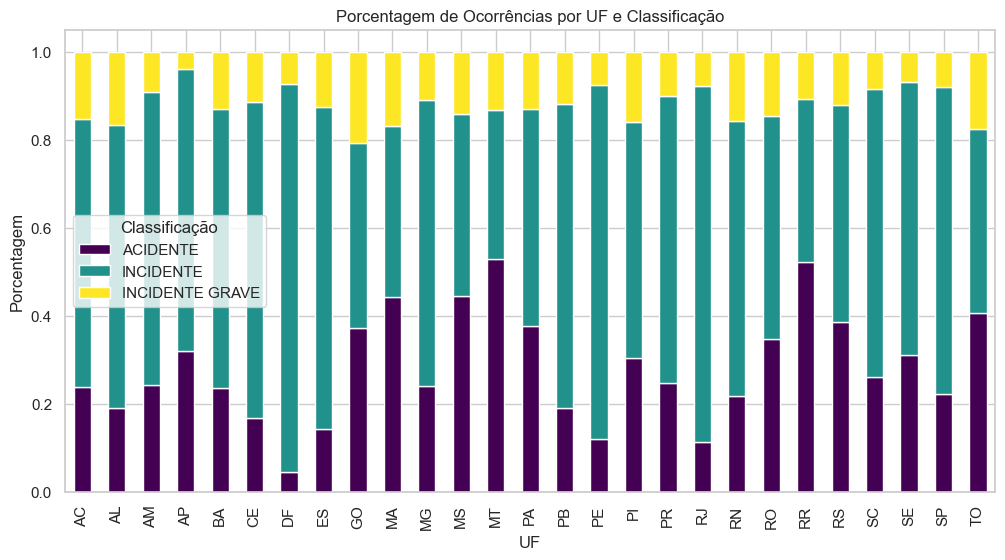

In [74]:
# Calculate the percentage of each classification within each UF
classification_counts = df.groupby(['ocorrencia_uf', 'ocorrencia_classificacao']).size().unstack().fillna(0)
classification_percentages = classification_counts.div(classification_counts.sum(axis=1), axis=0)

# Plot the stacked bar chart
classification_percentages.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Porcentagem de Ocorrências por UF e Classificação')
plt.xlabel('UF')
plt.ylabel('Porcentagem')
plt.legend(title='Classificação')
plt.show()

In general, in all states, INCIDENTES GRAVES appear in about 10% of cases, a stable number that is not found in the number of ACIDENTES. This is more pronounced for MT and PR.

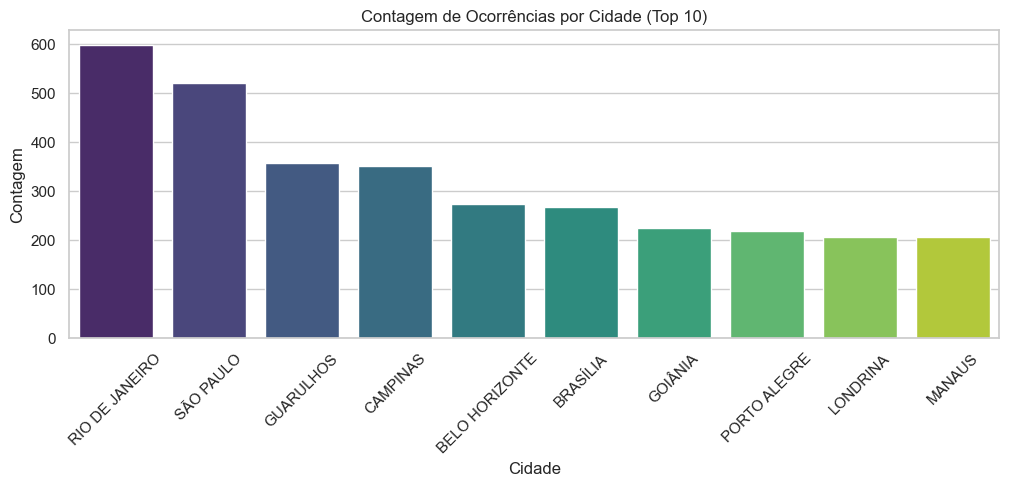

In [75]:
# Calculate the top 10 cities with the most occurrences
top_10_cities = df['ocorrencia_cidade'].value_counts().reset_index()
top_10_cities.columns = ['ocorrencia_cidade', 'count']

plt.figure(figsize=(12, 4))
sns.barplot(x='ocorrencia_cidade', y='count', data=top_10_cities.head(10), palette='viridis')
plt.title('Contagem de Ocorrências por Cidade (Top 10)')
plt.ylabel('Contagem')
plt.xlabel('Cidade')
plt.xticks(rotation=45)
plt.show()

If we expand the analysis to the cities, we notice some that are not capitals but are points of interest for travel or have a large population of residents. Campinas and Londrina fit this idea, while Guarulhos is also the airport near the capital of SP with the most flights.

### Question 2

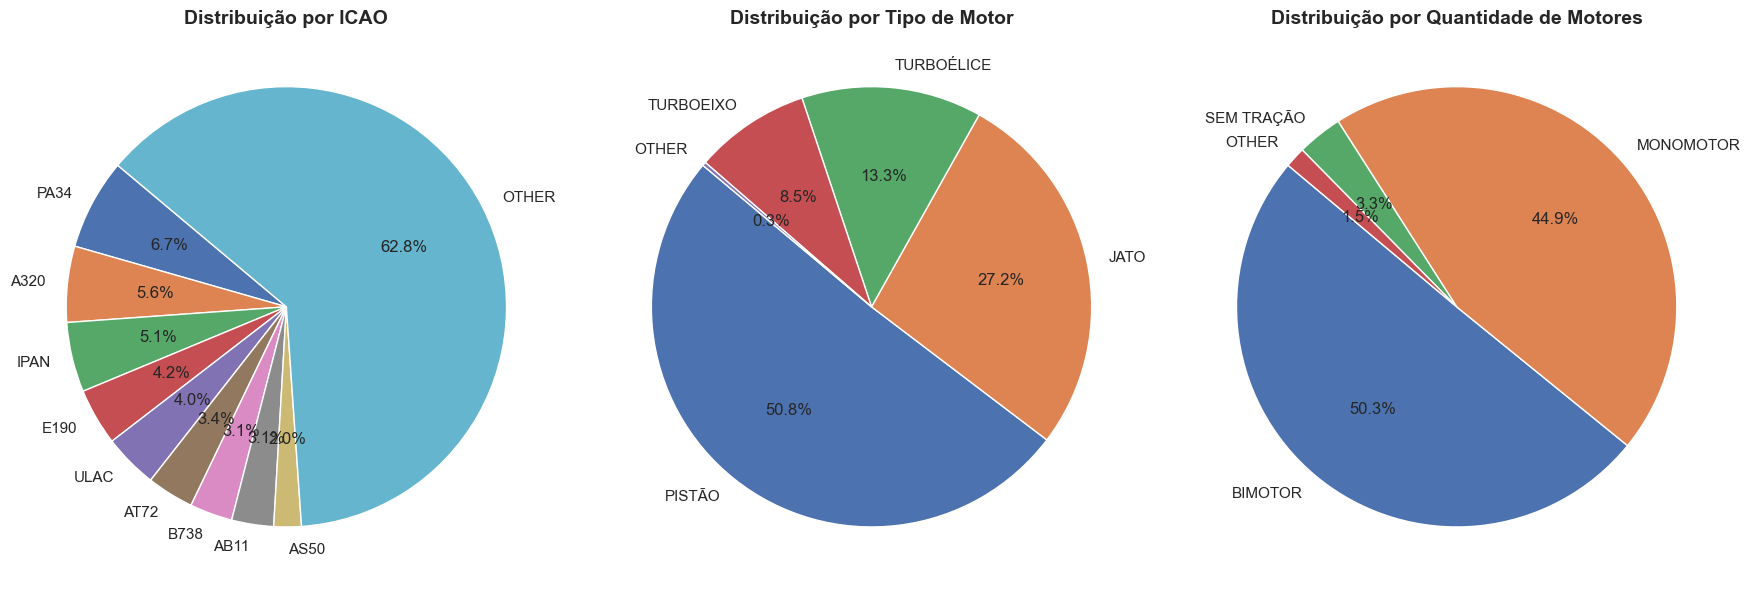

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot aeronave_tipo_icao
vehicle_counts = df['aeronave_tipo_icao'].value_counts(normalize=True)
vehicle_counts = pd.concat([vehicle_counts[vehicle_counts >= 0.02], pd.Series(vehicle_counts[vehicle_counts < 0.02].sum(), index=['OTHER'])])
vehicle_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axes[0])
axes[0].set_title('Distribuição por ICAO', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# Plot aeronave_motor_tipo
motor_type_counts = df['aeronave_motor_tipo'].value_counts(normalize=True)
motor_type_counts = pd.concat([motor_type_counts[motor_type_counts >= 0.02], pd.Series(motor_type_counts[motor_type_counts < 0.02].sum(), index=['OTHER'])])
motor_type_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axes[1])
axes[1].set_title('Distribuição por Tipo de Motor', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
motor_type_list = motor_type_counts.index.tolist()
motor_type_list.pop()

# Plot aeronave_motor_quantidade
motor_quantity_counts = df['aeronave_motor_quantidade'].value_counts(normalize=True)
motor_quantity_counts = pd.concat([motor_quantity_counts[motor_quantity_counts >= 0.02], pd.Series(motor_quantity_counts[motor_quantity_counts < 0.02].sum(), index=['OTHER'])])
motor_quantity_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axes[2])
axes[2].set_title('Distribuição por Quantidade de Motores', fontsize=14, fontweight='bold')
axes[2].set_ylabel('')
motor_quantity_list = motor_quantity_counts.index.tolist()
motor_quantity_list.pop()

plt.tight_layout()
plt.show()

In the context of the dataset, aeronave_tipo_icao probably refers to the type of aircraft as defined by the ICAO (International Civil Aviation Organization) code. The ICAO code is an international standard that classifies different types of aircraft.
Through it, we cannot perceive any type that stands out much, but evaluating the variables related to the engine, there are some types that appear more frequently.

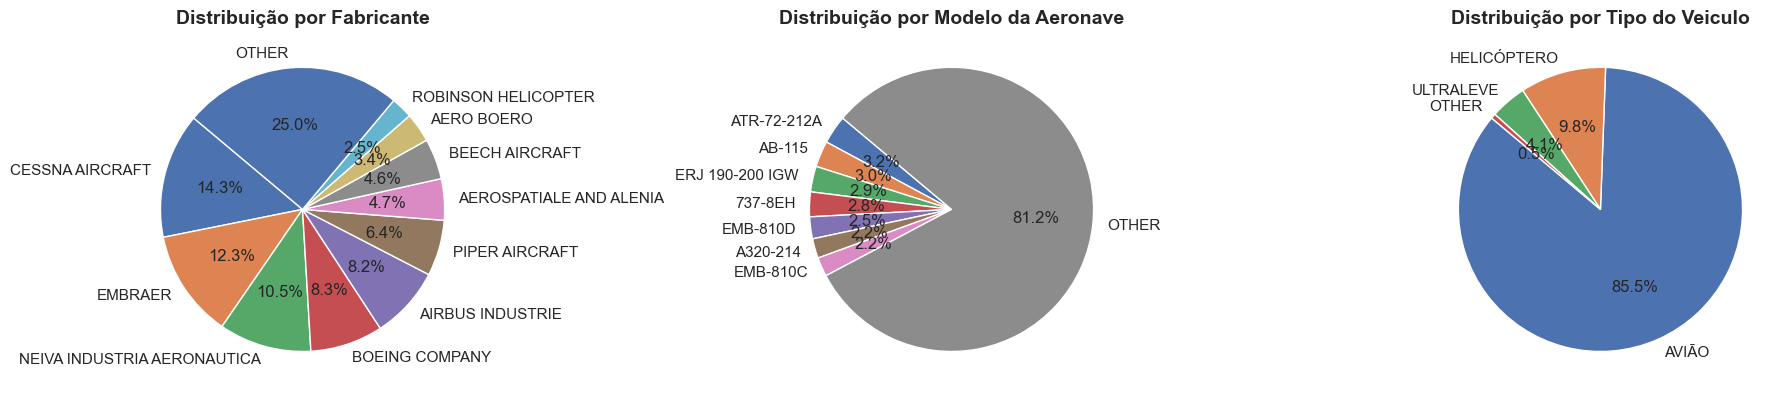

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

minimum_percentage_count = 0.02

# Plot aeronave_fabricante
vehicle_counts = df['aeronave_fabricante'].value_counts(normalize=True)
vehicle_counts = pd.concat([vehicle_counts[vehicle_counts >= minimum_percentage_count], pd.Series(vehicle_counts[vehicle_counts < minimum_percentage_count].sum(), index=['OTHER'])])
vehicle_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axes[0])
axes[0].set_title('Distribuição por Fabricante', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# Plot aeronave_modelo
motor_type_counts = df['aeronave_modelo'].value_counts(normalize=True)
motor_type_counts = pd.concat([motor_type_counts[motor_type_counts >= minimum_percentage_count], pd.Series(motor_type_counts[motor_type_counts < minimum_percentage_count].sum(), index=['OTHER'])])
motor_type_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axes[1])
axes[1].set_title('Distribuição por Modelo da Aeronave', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

# Plot aeronave_tipo_veiculo
vehicle_type_counts = df['aeronave_tipo_veiculo'].value_counts(normalize=True)
vehicle_type_counts = pd.concat([vehicle_type_counts[vehicle_type_counts >= minimum_percentage_count], pd.Series(vehicle_type_counts[vehicle_type_counts < minimum_percentage_count].sum(), index=['OTHER'])])
vehicle_type_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axes[2])
axes[2].set_title('Distribuição por Tipo do Veiculo', fontsize=14, fontweight='bold')
axes[2].set_ylabel('')
vehycle_type_list = vehicle_type_counts.index.tolist()
vehycle_type_list.pop()

plt.tight_layout()
plt.show()

Here, the models of the aircraft are very well distinguished from each other, while their manufacturers are mostly 5 companies from the aeronautical industry, but the type of vehicle that appears the most is the airplane, which reflects reality well.

From these visualizations, we can discard some variables whose categories are many and with little individual significance and try to outline a profile of the aircraft.

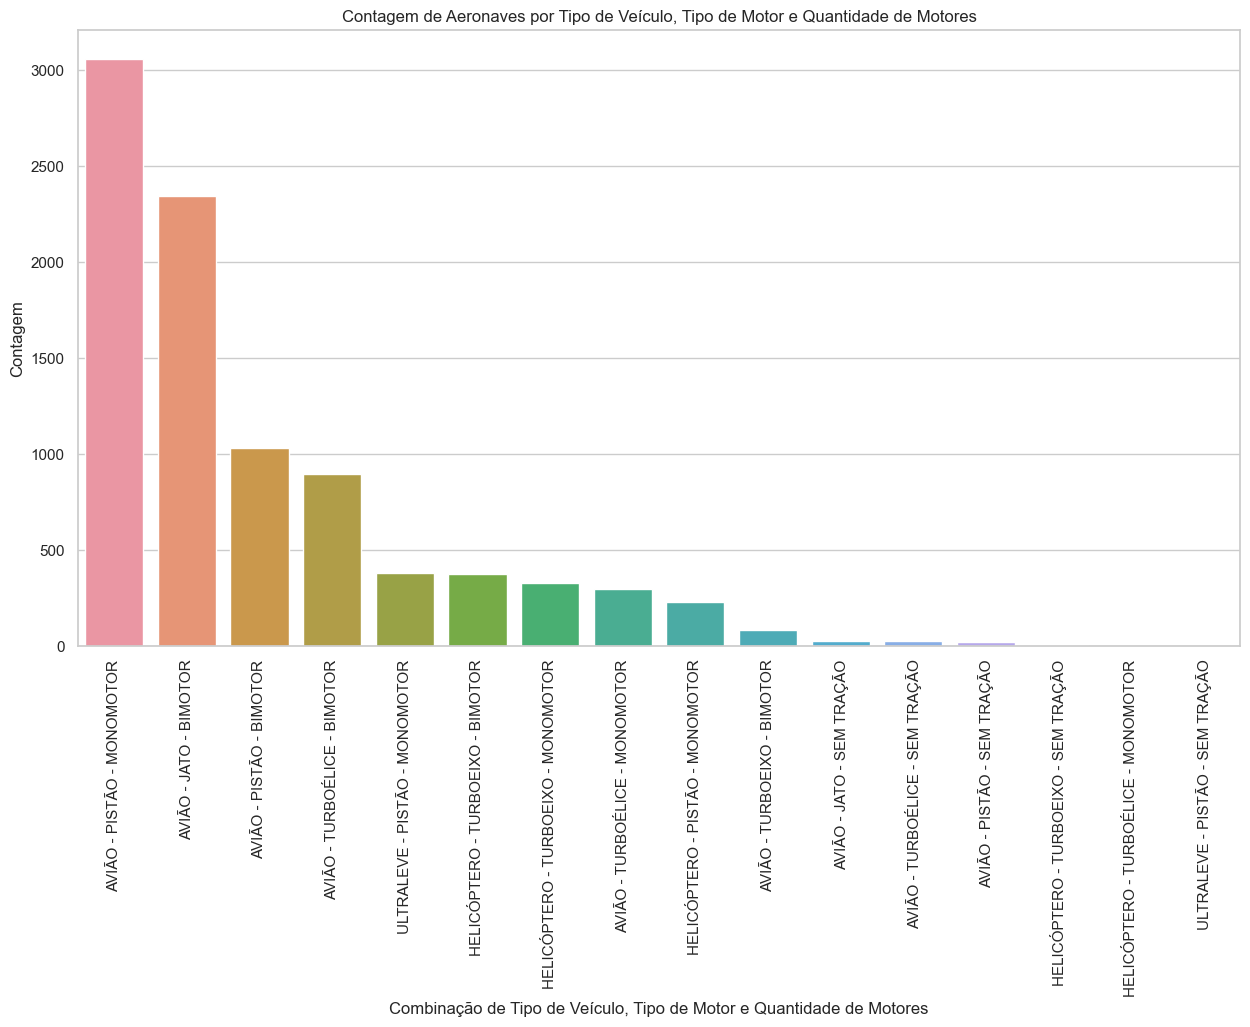

In [78]:
filtered_df = df[
    (df['aeronave_motor_tipo'].isin(motor_type_list)) &
    (df['aeronave_motor_quantidade'].isin(motor_quantity_list)) &
    (df['aeronave_tipo_veiculo'].isin(vehycle_type_list))
]

# Group by the specified columns and count occurrences
grouped_df = filtered_df.groupby(['aeronave_tipo_veiculo', 'aeronave_motor_tipo', 'aeronave_motor_quantidade']).size().reset_index(name='count')

# Plot the bar chart
grouped_df['combination'] = grouped_df['aeronave_tipo_veiculo'] + ' - ' + grouped_df['aeronave_motor_tipo'] + ' - ' + grouped_df['aeronave_motor_quantidade']
grouped_df = grouped_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(15, 8))
sns.barplot(x='combination', y='count', data=grouped_df)
plt.title('Contagem de Aeronaves por Tipo de Veículo, Tipo de Motor e Quantidade de Motores')
plt.ylabel('Contagem')
plt.xlabel('Combinação de Tipo de Veículo, Tipo de Motor e Quantidade de Motores')
plt.xticks(rotation=90)
plt.show()

According to this graph, we can highlight 4 vehicle profiles with very diverse engine configurations that appear the most, in order:
- Airplane with single piston engine;
- Airplane with twin jet engines;
- Airplane with twin piston engines;
- Airplane with twin turboprop engines.

<Figure size 1500x800 with 0 Axes>

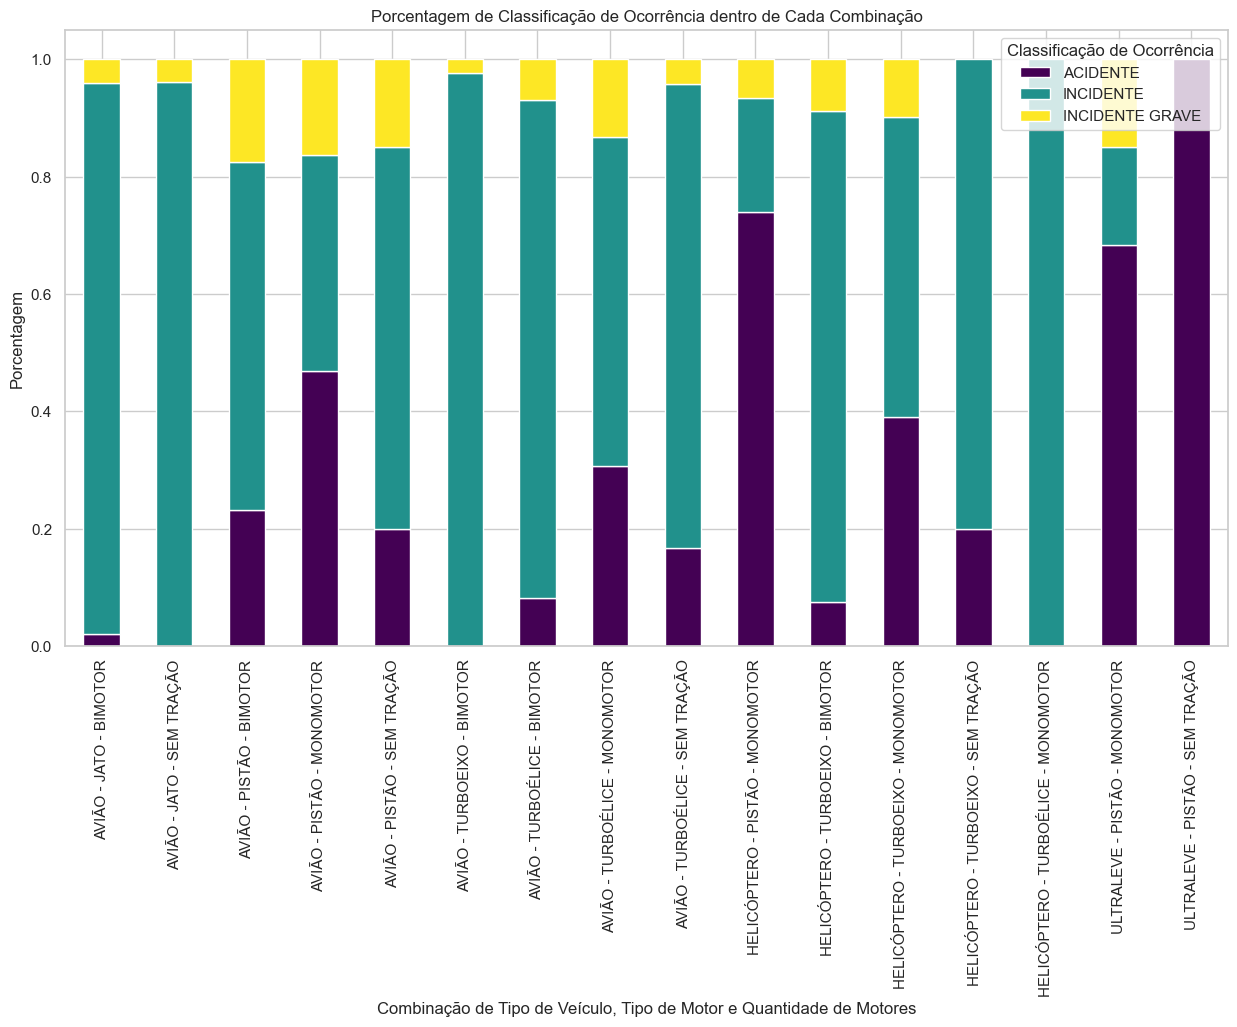

In [79]:
filtered_df = df[
    (df['aeronave_motor_tipo'].isin(motor_type_list)) &
    (df['aeronave_motor_quantidade'].isin(motor_quantity_list)) &
    (df['aeronave_tipo_veiculo'].isin(vehycle_type_list))
]

# Group by the specified columns and count occurrences
grouped_df = filtered_df.groupby(['aeronave_tipo_veiculo', 'aeronave_motor_tipo', 'aeronave_motor_quantidade', 'ocorrencia_classificacao']).size().reset_index(name='count')
grouped_df['combination'] = grouped_df['aeronave_tipo_veiculo'] + ' - ' + grouped_df['aeronave_motor_tipo'] + ' - ' + grouped_df['aeronave_motor_quantidade']
grouped_df = grouped_df.sort_values(by='count', ascending=False)

grouped_df['percentage'] = grouped_df.groupby('combination')['count'].transform(lambda x: x / x.sum())

# Plot the stacked bar chart
plt.figure(figsize=(15, 8))
grouped_df_pivot = grouped_df.pivot(index='combination', columns='ocorrencia_classificacao', values='percentage')
grouped_df_pivot.plot(kind='bar', stacked=True, colormap='viridis', figsize=(15, 8))
plt.title('Porcentagem de Classificação de Ocorrência dentro de Cada Combinação')
plt.ylabel('Porcentagem')
plt.xlabel('Combinação de Tipo de Veículo, Tipo de Motor e Quantidade de Motores')
plt.xticks(rotation=90)
plt.legend(title='Classificação de Ocorrência')
plt.show()

Among the 4 profiles highlighted earlier, we can notice 2 with extreme occurrence classification indices:
- Airplane with single piston engine: high percentage of accidents and serious incidents;
- Airplane with twin jet engines: low percentage of accidents and serious incidents.

This, along with the following graph, indicates that the jet engine is safer than the piston engine.

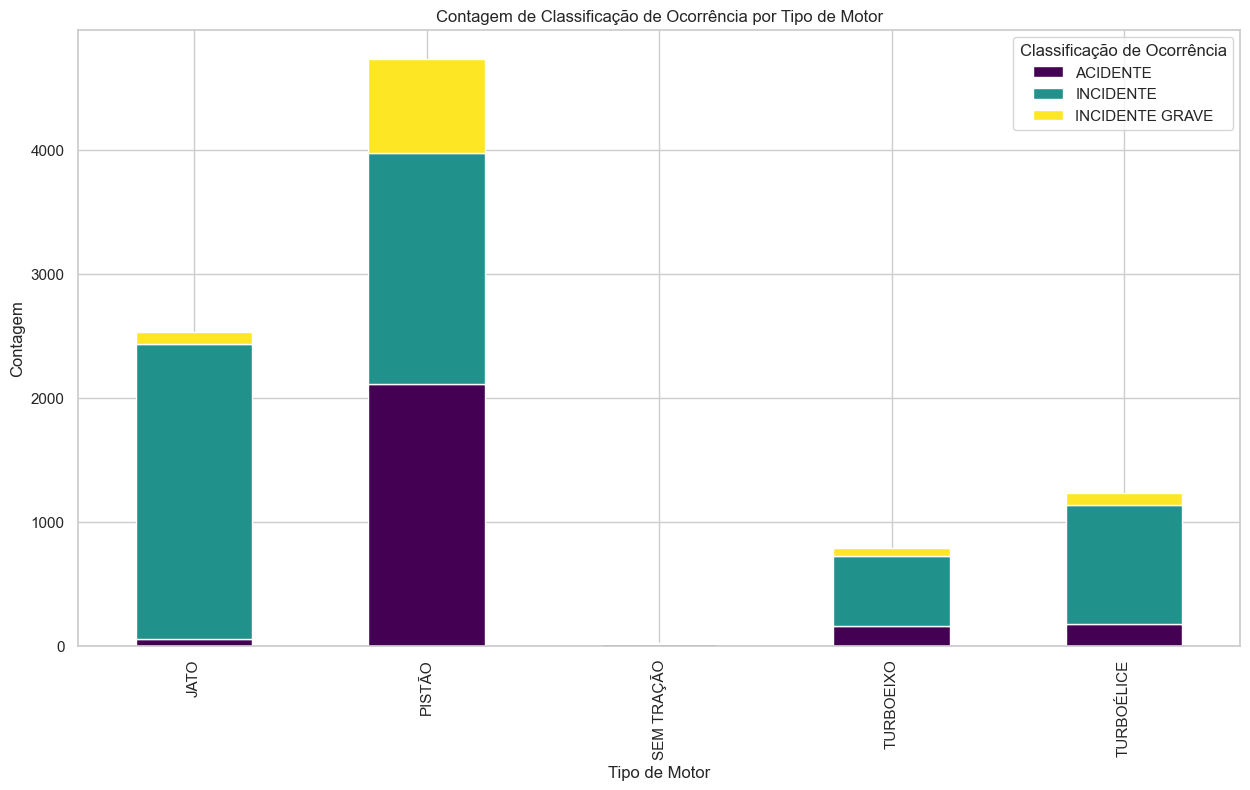

In [80]:
grouped_df = df[df['aeronave_motor_tipo'] != 'OTHER'].groupby(['aeronave_motor_tipo', 'ocorrencia_classificacao']).size().unstack().fillna(0)
grouped_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(15, 8))
plt.title('Contagem de Classificação de Ocorrência por Tipo de Motor')
plt.ylabel('Contagem')
plt.xlabel('Tipo de Motor')
plt.legend(title='Classificação de Ocorrência')
plt.show()

### Question 3

Let the values in parentheses be the sample of data used to calculate the average number of seats, value grouped based on the category and the number of fatalities of the aircraft.

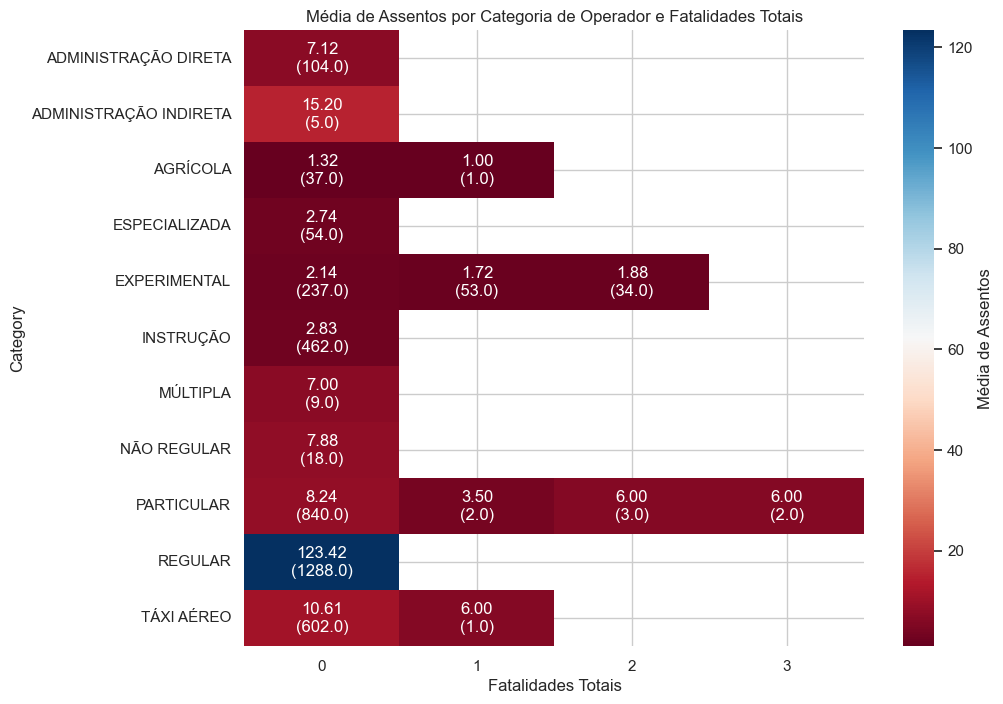

In [81]:
mean_values = df.groupby(['aeronave_operador_categoria', 'aeronave_fatalidades_total'])['aeronave_assentos'].mean().unstack()
count_values = df.groupby(['aeronave_operador_categoria', 'aeronave_fatalidades_total'])['aeronave_assentos'].size().unstack()
annot = mean_values.copy().astype(str)
for i in mean_values.index:
    for j in mean_values.columns:
        annot.at[i, j] = f'{mean_values.at[i, j]:.2f}\n({count_values.at[i, j]})'

plt.figure(figsize=(10, 8))
sns.heatmap(mean_values, annot=annot, cmap='RdBu', fmt='', cbar_kws={'label': 'Média de Assentos'})
plt.title('Média de Assentos por Categoria de Operador e Fatalidades Totais')
plt.xlabel('Fatalidades Totais')
plt.ylabel('Category')
plt.show()

Based on the heatmap, we can see that most fatalities in occurrences are precisely due to experimental flights with a low number of seats, which is expected to have few passengers and a level of risk.  
Regular flights are the most common and cannot have a risk of fatality, something evidenced by the lack of data pointing to any deaths and their high number of seats.  
The other categories are also commonly used for specific purposes where few people board, meaning it is consistent with a low number of seats. Additionally, private use is subject to fewer legislative concerns, meaning less care compared to regular flights.

### Question 4

In [82]:
minimum_percentage_count = 0.02

factor_name_counts = df['fator_nome'].value_counts(normalize=True)
factor_name_counts = pd.concat([factor_name_counts[factor_name_counts >= minimum_percentage_count], pd.Series(factor_name_counts[factor_name_counts < minimum_percentage_count].sum(), index=['OTHER'])])
factor_name_list = factor_name_counts.index.tolist()
factor_name_list.pop()

'OTHER'

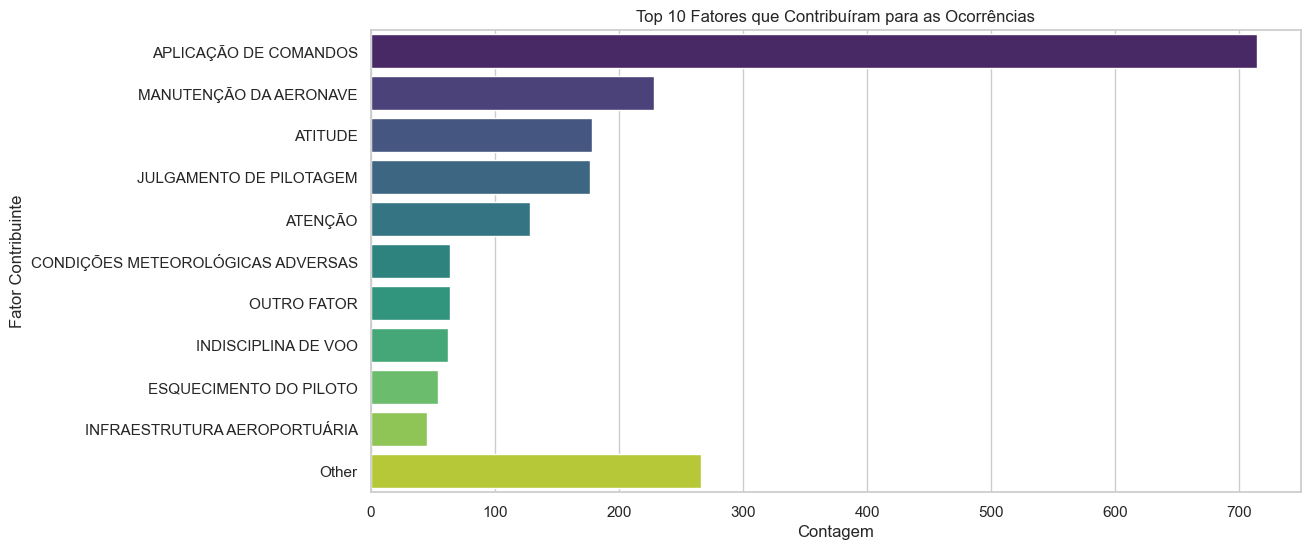

In [83]:
# group by fator_nome and count the occurrences
grouped_df = df.groupby('fator_nome').size().reset_index(name='count')

# sort the values and get the top 10
top_10_df = grouped_df.sort_values(by='count', ascending=False).head(10)

# calculate the sum of all other factors
other_count = grouped_df['count'].sum() - top_10_df['count'].sum()

# append the 'Other' row to the top 10 dataframe
other_row = pd.DataFrame({'fator_nome': ['Other'], 'count': [other_count]})
top_10_df = pd.concat([top_10_df, other_row], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='fator_nome', data=top_10_df, palette='viridis')
plt.title('Top 10 Fatores que Contribuíram para as Ocorrências')
plt.ylabel('Fator Contribuinte')
plt.xlabel('Contagem')
plt.show()

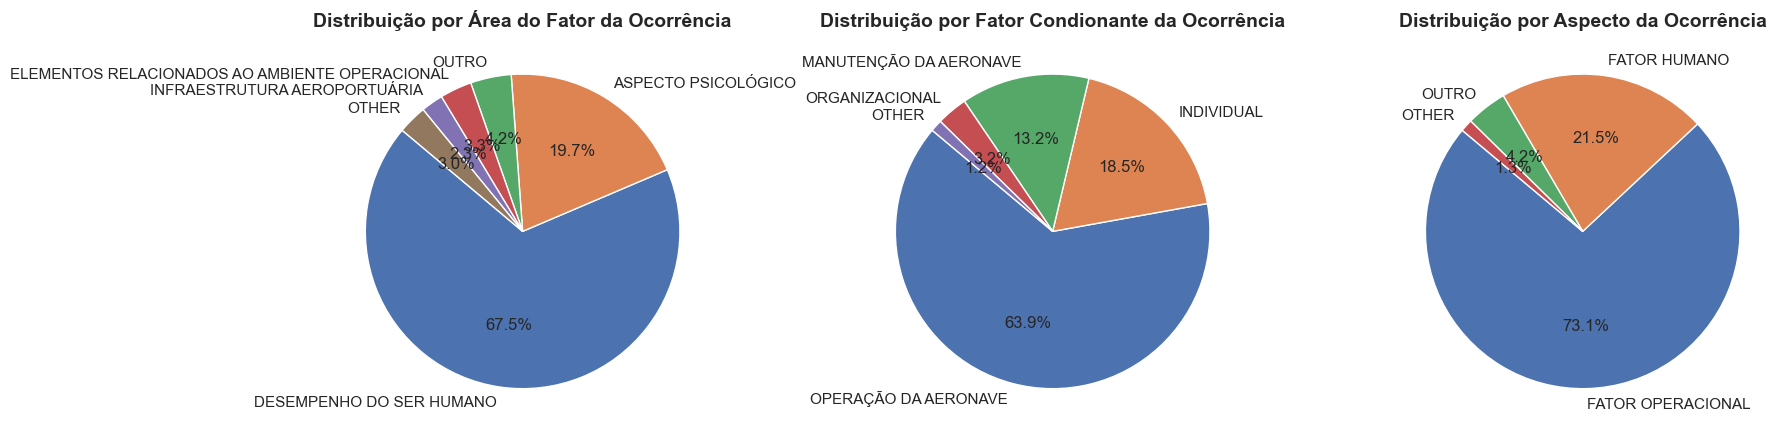

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

minimum_percentage_count = minimum_percentage_count

# Plot fator_aspecto
aspect_counts = df['fator_aspecto'].value_counts(normalize=True)
aspect_counts = pd.concat([aspect_counts[aspect_counts >= minimum_percentage_count], pd.Series(aspect_counts[aspect_counts < minimum_percentage_count].sum(), index=['OTHER'])])
aspect_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axes[0])
axes[2].set_title('Distribuição por Aspecto da Ocorrência', fontsize=14, fontweight='bold')
axes[2].set_ylabel('')
aspect_list = aspect_counts.index.tolist()
aspect_list.pop()

# Plot fator_condicionante
conditioning_counts = df['fator_condicionante'].value_counts(normalize=True)
conditioning_counts = pd.concat([conditioning_counts[conditioning_counts >= minimum_percentage_count], pd.Series(conditioning_counts[conditioning_counts < minimum_percentage_count].sum(), index=['OTHER'])])
conditioning_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axes[1])
axes[1].set_title('Distribuição por Fator Condionante da Ocorrência', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
conditioning_list = conditioning_counts.index.tolist()
conditioning_list.pop()

# Plot fator_area
area_counts = df['fator_area'].value_counts(normalize=True)
area_counts = pd.concat([area_counts[area_counts >= minimum_percentage_count], pd.Series(area_counts[area_counts < minimum_percentage_count].sum(), index=['OTHER'])])
area_counts.plot.pie(autopct='%1.1f%%', startangle=140, ax=axes[2])
axes[0].set_title('Distribuição por Área do Fator da Ocorrência', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')
area_list = area_counts.index.tolist()
area_list.pop()

plt.tight_layout()
plt.show()

Just with these two graphs, it is already possible to confirm that the main cause of occurrences is due to the human factor, but let's go deeper to find the profiles.

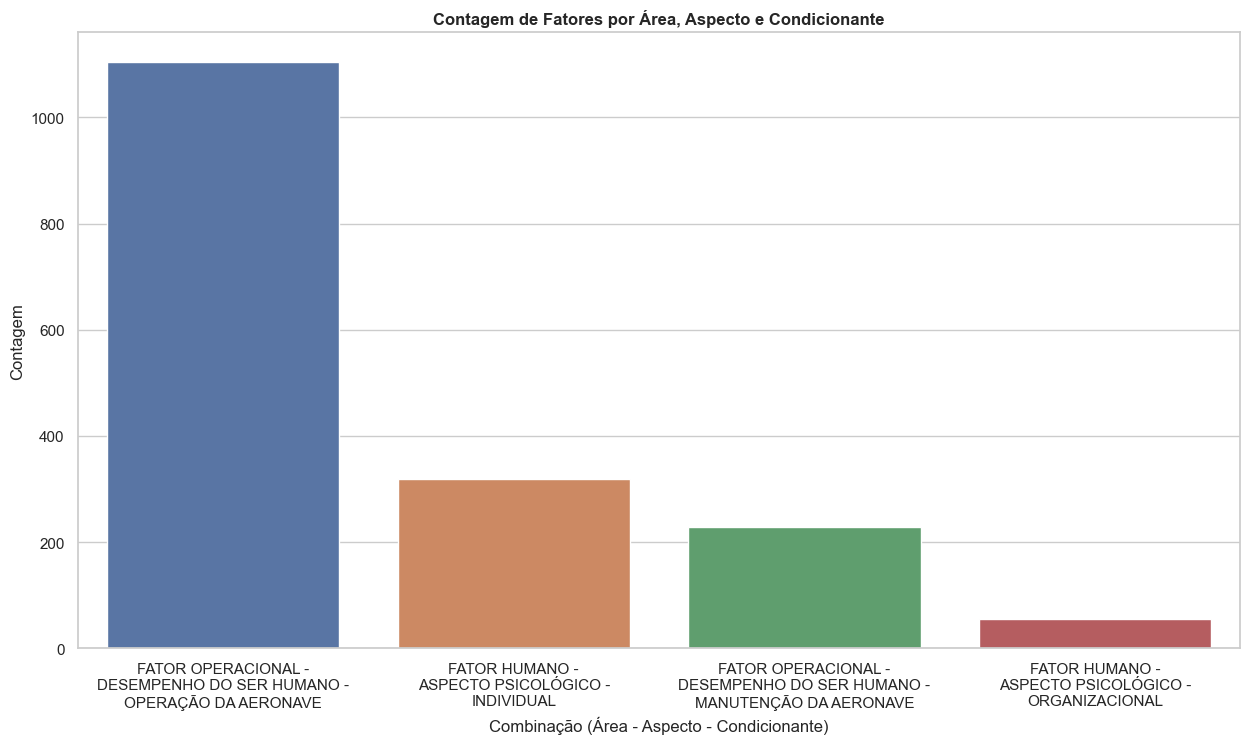

In [85]:
filtered_df = df[
    (df['fator_aspecto'].isin(aspect_list)) &
    (df['fator_condicionante'].isin(conditioning_list)) &
    (df['fator_area'].isin(area_list))
]

# Group by the specified columns and count occurrences
grouped_df = filtered_df.groupby(['fator_area', 'fator_aspecto', 'fator_condicionante']).size().reset_index(name='count')

# Plot the bar chart
grouped_df['combination'] = grouped_df['fator_area'] + ' -\n' + grouped_df['fator_aspecto'] + ' -\n' + grouped_df['fator_condicionante']
grouped_df = grouped_df.sort_values(by='count', ascending=False)
plt.figure(figsize=(15, 8))
sns.barplot(x='combination', y='count', data=grouped_df)
plt.title('Contagem de Fatores por Área, Aspecto e Condicionante', fontweight='bold')
plt.ylabel('Contagem')
plt.xlabel('Combinação (Área - Aspecto - Condicionante)')
plt.xticks(rotation=0)
plt.show()

Here it is possible to infer more accurately that the highest percentage of occurrences is due to the human factor, where there seem to be piloting errors or even preparation of the aircraft for the flight.

### Question 5

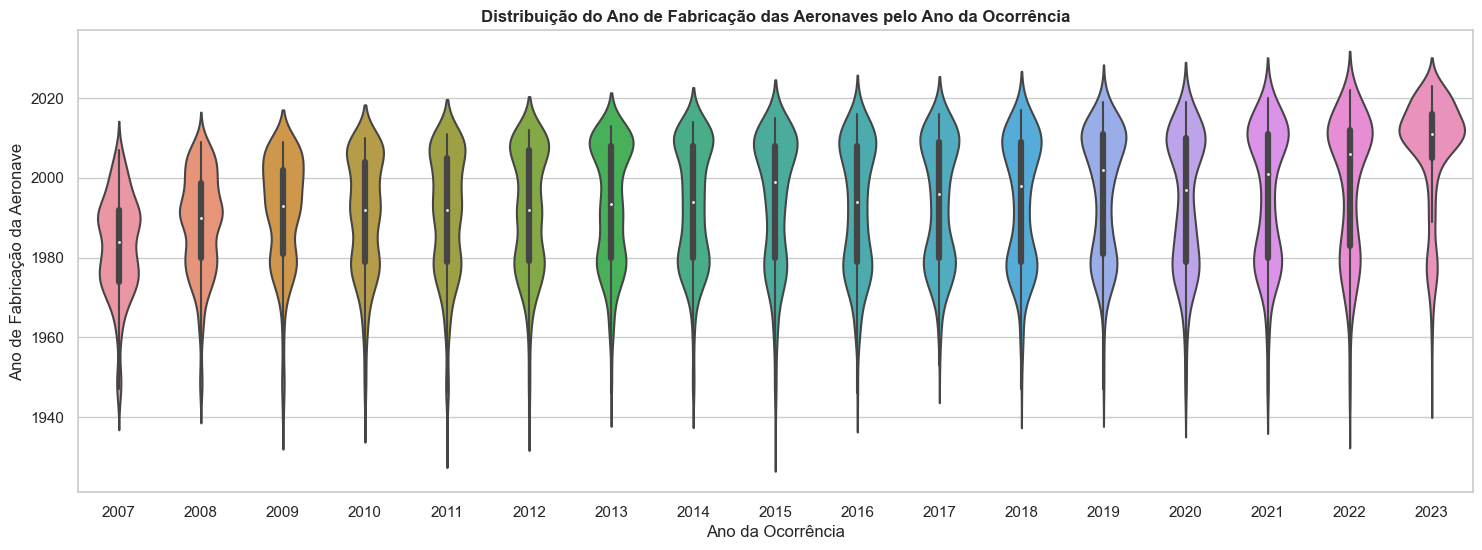

In [86]:
k = df
k['ocorrencia_ano'] = df['ocorrencia_dia'].dt.year

plt.figure(figsize=(18, 6))
sns.violinplot(x='ocorrencia_ano', y='aeronave_ano_fabricacao', data=k)
plt.title('Distribuição do Ano de Fabricação das Aeronaves pelo Ano da Ocorrência', fontweight='bold')
plt.xlabel('Ano da Ocorrência')
plt.ylabel('Ano de Fabricação da Aeronave')
plt.show()

We can notice that until 2021 it was very common for occurrences to be, in a good percentage, about aircraft from decades ago. From 2022 to 2023 we see a decrease in the use of old aircraft. It can be said that older aircraft are present in most occurrences, but, compared to more current ones, there is not enough quantity to affirm that this is a relevant factor, whether due to machine malfunctions or lack of newer resources that assist the pilot.